In [2]:
import numpy as np
import pandas as pd
# import scipy.io
# from scipy import stats

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# from tqdm import tqdm
import os

%load_ext autoreload
%autoreload 2

In [3]:
repo_dir = r'C:\Users\ll357\Documents\inter'.replace("\\", "/")
os.chdir(repo_dir)
from src import adp

# load grat1

In [542]:
data_dir_grat = r'\\duhs-user-nc1.dhe.duke.edu\dusom_glickfeldlab\All_Staff\home\lan\Data\2P_images\mat_inter\V1_i1372_220714_cellpose'
stim_id, trace_by_trial = adp.load_trace_trial_data(data_dir_grat, vis_filter=False)
stim_id = stim_id[:trace_by_trial.shape[1]] # truncate to uncorrupted trials
trace_avg_cell, trace_cell_sem, trace_stim_avg = adp.calc_trace_stim(trace_by_trial, stim_id)

ncell: 56, nstim: 1, ntrial: 219, nframe: 267
trace_cell_avg: (267,).         trace_stim_avg list len: 1.         trace_stim_avg[0].shape: (267,)


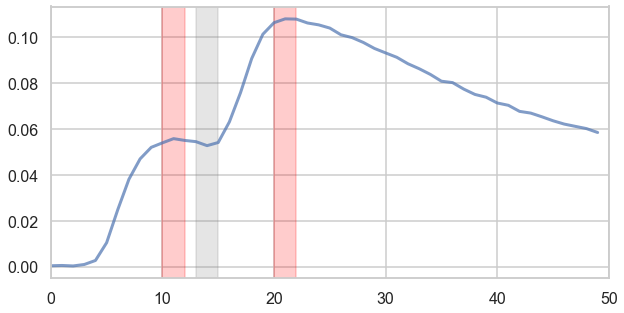

In [543]:
fig, ax = plt.subplots(figsize=(10, 5))
plt.plot(trace_avg_cell[:50], alpha=0.7, linewidth=3)
ax.axvspan(10, 12, alpha=0.2, color='red')
ax.axvspan(13, 15, alpha=0.2, color='gray')
ax.axvspan(20, 22, alpha=0.2, color='red')
plt.xlim(0, 50);

# adp
estimate how many trials to group together to get a stable adaptation value  
1. trace_by_trial shape: ncell x ntrial x nframe  
2. for each cell x trial, get resp_ad and resp_tg  
3. for whole population, loop thru trial numbers to group together to get a stable adaptation value  
3.1 measure adp value stability: plot group_size vs adp_mean & adp_std  
4. do this for each cell  
4.1 distribution of stable_group_size among cells  

In [544]:
# get resp_ad and resp_tg [cell x trial]
base1 = trace_by_trial[:,:,0:2+1].mean(axis=2) # avg over time window frames
resp_ad = trace_by_trial[:,:,10:12+1].mean(axis=2)
resp_ad = resp_ad - base1

base2 = trace_by_trial[:,:,13:15+1].mean(axis=2)
resp_tg = trace_by_trial[:,:,20:22+1].mean(axis=2)
resp_tg = resp_tg - base2

## clip extreme resp

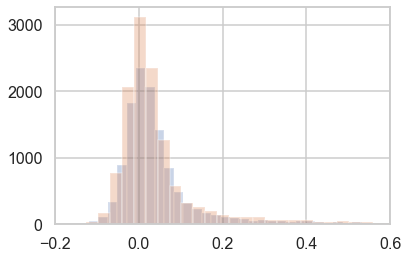

In [545]:
plt.hist(resp_ad.ravel(), bins=100, alpha=0.3, label='AD');
plt.hist(resp_tg.ravel(), bins=100, alpha=0.3, label='TG');
plt.xlim(-0.2, 0.6);

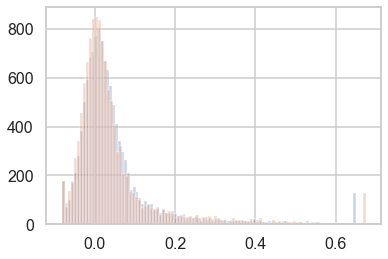

In [546]:
# cap resp to thres_perc percentile of trials

thres_perc = 1
low, high = np.percentile(resp_ad.flatten(), [thres_perc, 100-thres_perc])
resp_ad = np.clip(resp_ad, low, high)
plt.hist(resp_ad.ravel(), bins=100, alpha=0.3, label='AD');

low, high = np.percentile(resp_tg.flatten(), [thres_perc, 100-thres_perc])
resp_tg = np.clip(resp_tg, low, high)
plt.hist(resp_tg.ravel(), bins=100, alpha=0.3, label='TG');


## pop adp stability
population of 56 cells need 10-20 trials to get a stable adaptation value  
regardless of using mean or median to aggregate  
but using median gets abs larger adp value than mean

In [554]:
mean_or_median = np.median # for population, median is better than mean

resp_ad_pop = mean_or_median(resp_ad, axis=0) # population response as avg or median of all cells for each trial
resp_tg_pop = mean_or_median(resp_tg, axis=0)

adp_norm_diff = (resp_tg_pop - resp_ad_pop) / (resp_ad_pop + 1e-7) # difference over baseline
adp_IOU = (resp_tg_pop - resp_ad_pop) / (resp_tg_pop + resp_ad_pop + 1e-7) # difference over sum
adp_norm_diff.shape, mean_or_median(adp_norm_diff), mean_or_median(adp_IOU) # group_size = 1, use all cell resp mean or median

((219,), -0.3218938759212324, -0.11172270297723275)

In [555]:
# shuffle resp_ad_pop and resp_tg_pop the same way
np.random.seed(42)
idx = np.random.permutation(resp_ad_pop.shape[0])
resp_ad_pop_shuf = resp_ad_pop[idx]
resp_tg_pop_shuf = resp_tg_pop[idx]

# for whole population, loop thru trial numbers to group together to get a stable adaptation value  
adp_agg = []
adp_std = []
for group_size in np.arange(1, trace_by_trial.shape[1] // 2):
    ngroup = trace_by_trial.shape[1] // group_size

    resp_ad_cut = resp_ad_pop_shuf[:group_size*ngroup].reshape(ngroup, group_size) # reshape to ngroup x group_size
    resp_tg_cut = resp_tg_pop_shuf[:group_size*ngroup].reshape(ngroup, group_size)
    resp_ad_group = mean_or_median(resp_ad_cut, axis=1) # aggregate resp within group of trials
    resp_tg_group = mean_or_median(resp_tg_cut, axis=1)

    adp_group = (resp_tg_group - resp_ad_group) / (resp_ad_group + 1e-7) # calc adp with `avg resp within group`
    adp_group_agg = mean_or_median(adp_group) # agg adp across group
    adp_group_std = np.std(adp_group) # std of adp across group
    adp_agg.append(adp_group_agg) # group_size variable, all cell resp agg
    adp_std.append(adp_group_std)

adp_agg = np.array(adp_agg)
adp_std = np.array(adp_std)
adp_sem = adp_std / np.sqrt(adp_std.shape[0])

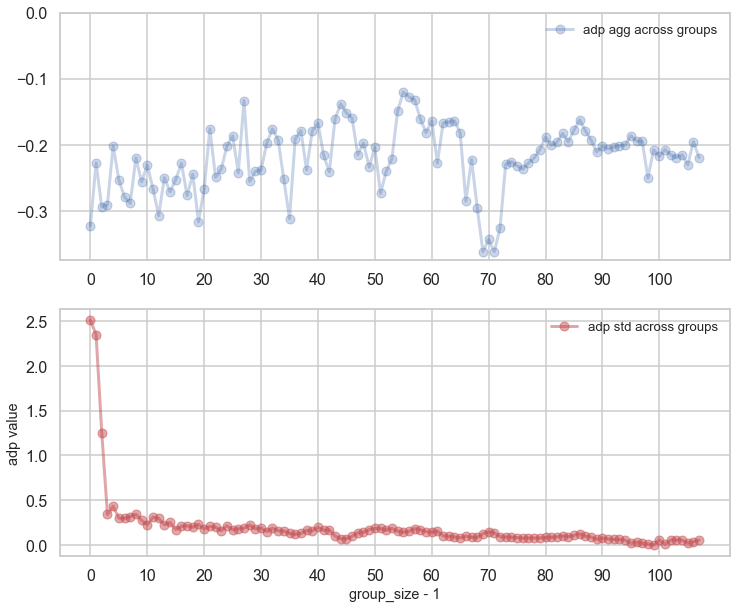

In [556]:
plt.figure(figsize=(12, 10))
plt.subplot(2,1,1)
plt.plot(adp_agg, 'o-', color='b', linewidth=3, alpha=0.3, label='adp agg across groups')
# plt.axhline(-0.32, color='g')
plt.xticks(np.arange(0,110,10))
plt.ylim(plt.ylim()[0], 0)
plt.legend(frameon=False);

plt.subplot(2,1,2)
plt.plot(adp_std, 'o-', color='r', linewidth=3, alpha=0.5, label='adp std across groups')
plt.xticks(np.arange(0,110,10))
plt.xlabel('group_size - 1')
# plt.ylim(0, 0.5)
plt.ylabel('adp value')
plt.legend(frameon=False);

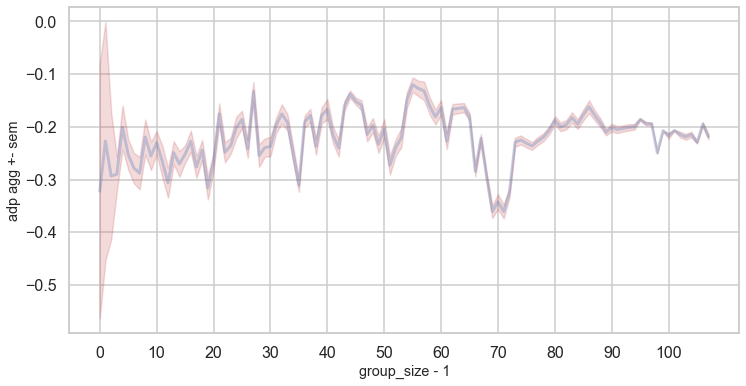

In [557]:
errbar = adp_sem # adp_std error bar too large to visliz

plt.figure(figsize=(12, 6))
plt.plot(adp_agg, '-', color='b', linewidth=3, alpha=0.3)
plt.fill_between(np.arange(len(adp_agg)), 
                 adp_agg + errbar, adp_agg - errbar, 
                 color='r', alpha=0.2)

plt.xticks(np.arange(0,110,10))
plt.xlabel('group_size - 1')
plt.ylabel('adp agg +- sem');

## single cell adp stability
single cells need 20-30 trials to get a stable adaptation value  

In [400]:
mean_or_median = np.median # for single cell, median is better than mean too

ncell = trace_by_trial.shape[0]
ngroup_min = 2
nsize = len(np.arange(1, trace_by_trial.shape[1] // ngroup_min)) # how many group_size to test
adp_cell_agg = np.zeros((ncell, nsize))
adp_cell_std = np.zeros((ncell, nsize))
adp_cell_sem = np.zeros((ncell, nsize))

for icell in np.arange(ncell):
    resp_ad_cell = resp_ad[icell, :]
    resp_tg_cell = resp_tg[icell, :]

    # shuffle resp_ad_pop and resp_tg_pop the same way
    np.random.seed(42)
    idx = np.random.permutation(resp_ad_pop.shape[0])
    resp_ad_cell_shuf = resp_ad_cell[idx]
    resp_tg_cell_shuf = resp_tg_cell[idx]

    for isize, group_size in enumerate(np.arange(1, trace_by_trial.shape[1] // ngroup_min)):
        ngroup = trace_by_trial.shape[1] // group_size

        resp_ad_cut = resp_ad_cell_shuf[:group_size*ngroup].reshape(ngroup, group_size)
        resp_tg_cut = resp_tg_cell_shuf[:group_size*ngroup].reshape(ngroup, group_size)
        resp_ad_group = np.sum(resp_ad_cut, axis=1)
        resp_tg_group = np.sum(resp_tg_cut, axis=1)

        adp_group = (resp_tg_group - resp_ad_group) / (resp_ad_group + 1e-7)
        adp_group_agg = mean_or_median(adp_group)
        adp_group_std = np.std(adp_group)
        adp_group_sem = adp_group_std / np.sqrt(adp_group.shape[0])
        adp_cell_agg[icell, isize] = adp_group_agg
        adp_cell_std[icell, isize] = adp_group_std
        adp_cell_sem[icell, isize] = adp_group_sem

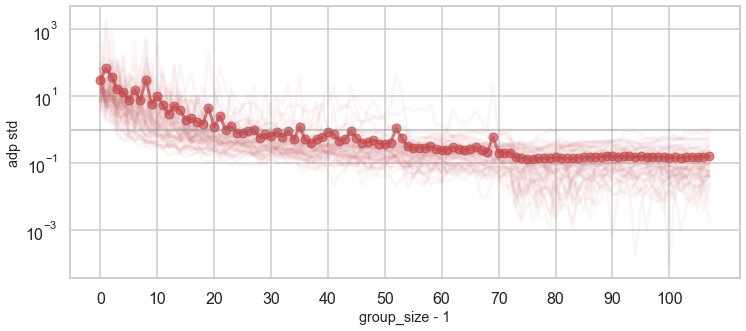

In [551]:
adp_cell_std_agg = mean_or_median(adp_cell_std, axis=0)

plt.figure(figsize=(12, 5))
plt.plot(adp_cell_std_agg, 'o-', color='r', linewidth=3, alpha=0.7, label='adp std across groups, agg over cells')
for icell in np.arange(ncell):
    plt.plot(adp_cell_std[icell, :], '-', color='r', linewidth=3, alpha=0.05, label='adp std across groups')

plt.axhline(1, alpha=0.4, color='gray')
plt.xticks(np.arange(0,110,10))
plt.xlabel('group_size - 1')

# plt.ylim(1e-3, plt.ylim()[1]) # set y axis lower limit
# plt.ylim(1e-2, 1e2)
plt.yscale('log')
plt.ylabel('adp std');

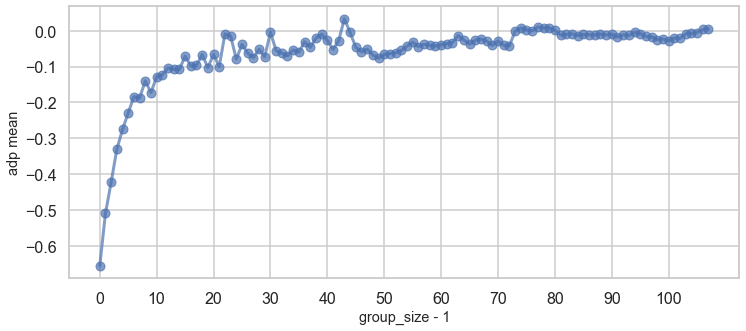

In [552]:
adp_cell_agg_agg = mean_or_median(adp_cell_agg, axis=0)

plt.figure(figsize=(12, 5))
plt.plot(adp_cell_agg_agg, 'o-', color='b', linewidth=3, alpha=0.7, label='adp agg across groups, agg over cells')
# for icell in np.arange(ncell):
#     plt.plot(adp_cell_agg[icell, :], '-', color='b', linewidth=3, alpha=0.05, label='adp agg across groups')

plt.xticks(np.arange(0,110,10))
plt.xlabel('group_size - 1')

# plt.yscale('symlog') # plot negative values on -log scale, plot ~0 values linearly: https://stackoverflow.com/questions/3305865/what-is-the-difference-between-log-and-symlog
# plt.ylim(-0.5,1)
plt.ylabel('adp mean');

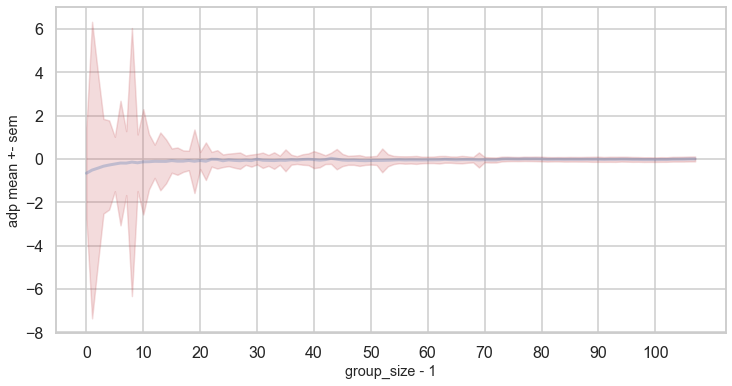

In [553]:
# errbar = adp_cell_std_agg

adp_cell_sem_agg = mean_or_median(adp_cell_sem, axis=0)
errbar = adp_cell_sem_agg

plt.figure(figsize=(12, 6))
plt.plot(adp_cell_agg_agg, '-', color='b', linewidth=3, alpha=0.3)
plt.fill_between(np.arange(len(adp_cell_agg_agg)), 
                adp_cell_agg_agg + errbar, adp_cell_agg_agg - errbar, color='r', alpha=0.2)

plt.xticks(np.arange(0,110,10))
plt.xlabel('group_size - 1')
# plt.yscale('symlog')
plt.ylabel('adp mean +- sem');

# load mix50
mix50 stim: Z:\All_Staff\home\lan\Mwork\mix50 - bunnytop high lum contrast mix grating and noise\Image

ncell: 169, nstim: 50, ntrial: 1473, nframe: 203
trace_cell_avg: (203,).         trace_stim_avg list len: 50.         trace_stim_avg[0].shape: (203,)


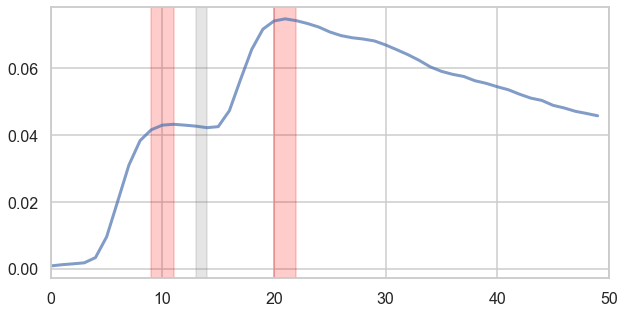

In [4]:
data_dir_grat = r'\\duhs-user-nc1.dhe.duke.edu\dusom_glickfeldlab\All_Staff\home\lan\Data\2P_images\mat_inter\V1_i1373_220909_cellpose'
stim_id, trace_by_trial = adp.load_trace_trial_data(data_dir_grat, vis_filter=True)
trace_avg_cell, trace_cell_sem, trace_stim_avg = adp.calc_trace_stim(trace_by_trial, stim_id)

fig, ax = plt.subplots(figsize=(10, 5))
plt.plot(trace_avg_cell[:50], alpha=0.7, linewidth=3)
ax.axvspan(9,11, alpha=0.2, color='red')
ax.axvspan(13,14, alpha=0.2, color='gray')
ax.axvspan(20,22, alpha=0.2, color='red')
plt.xlim(0, 50);

## trace by stim / type

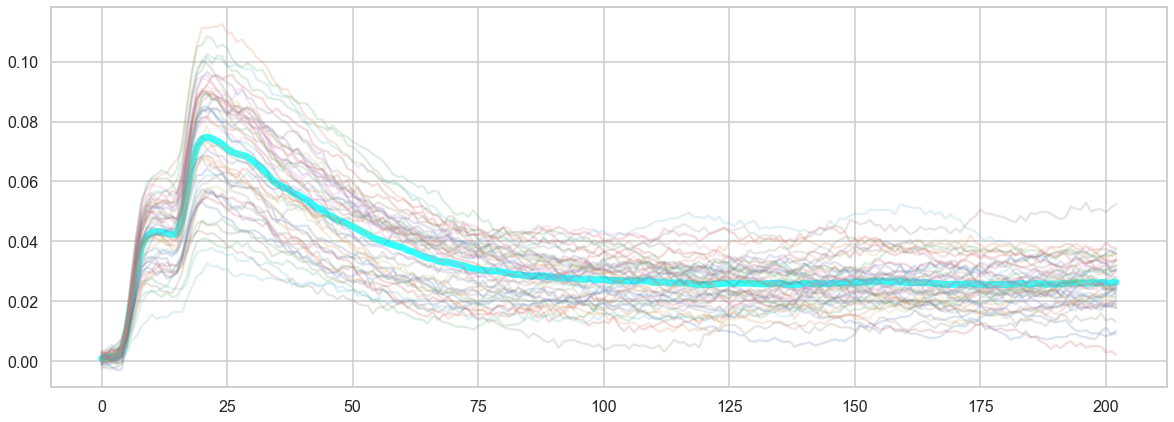

In [5]:
# plot trace for each stim
plt.figure(figsize=(20, 7))
plt.plot(trace_avg_cell, alpha=0.8, linewidth=7, color='cyan')
for i in np.unique(stim_id)-1:
    plt.plot(trace_stim_avg[i], alpha=0.2)

In [6]:
# plot trace for stim 1-30 (natural) vs stim 31-40 (grat) vs stim 41-50 (noise)

stim_type_dict = {'natural': [np.arange(1, 30+1)], 
                  'grat': [np.arange(31, 40+1)], 
                  'noise': [np.arange(41, 50+1)]}
for key in stim_type_dict.keys():
    print(key, stim_type_dict[key])
    
trace_type_avg = []
trace_type_std = []
trace_type_sem = []

for key in stim_type_dict.keys():
    
    trace_itype_avg = np.mean(trace_by_trial[:, np.where((np.isin(stim_id, stim_type_dict[key])))[0]], axis=1) # ncell x nframe
    trace_itype_avg = np.mean(trace_itype_avg, axis=0) # nframe
    trace_itype_std = np.std(trace_by_trial[:, np.where((np.isin(stim_id, stim_type_dict[key])))[0]], axis=1)
    trace_itype_std = np.mean(trace_itype_std, axis=0)
    trace_itype_sem = trace_itype_std / np.sqrt(len(np.where((np.isin(stim_id, stim_type_dict[key])))[0]))

    trace_type_avg.append(trace_itype_avg)
    trace_type_std.append(trace_itype_std)
    trace_type_sem.append(trace_itype_sem)

len(trace_type_avg), trace_type_avg[0].shape

natural [array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30])]
grat [array([31, 32, 33, 34, 35, 36, 37, 38, 39, 40])]
noise [array([41, 42, 43, 44, 45, 46, 47, 48, 49, 50])]


(3, (203,))

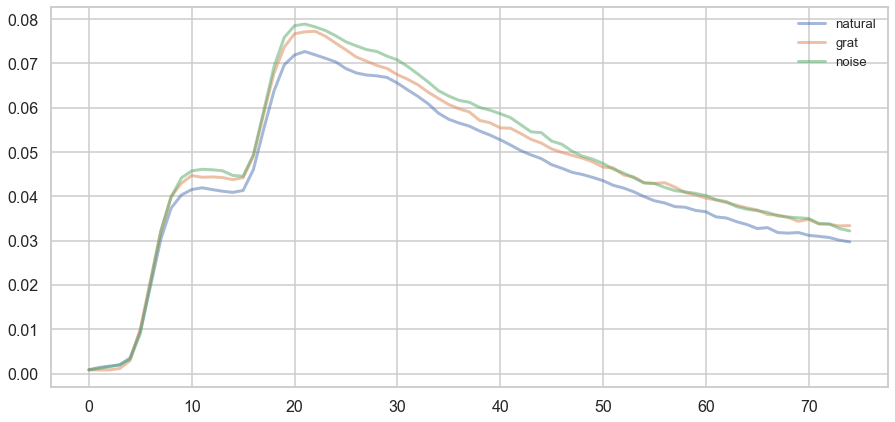

In [9]:
# plot trace for each stim type
plt.figure(figsize=(15, 7))

for i in np.arange(len(stim_type_dict.keys())):
    plt.plot(trace_type_avg[i][:75], alpha=0.5, linewidth=3)
    # errbar = trace_type_sem[i]
    # plt.fill_between(np.arange(len(trace_type_avg[i])), 
    #              trace_type_avg[i] + errbar, trace_type_avg[i] - errbar, 
    #              alpha=0.1)

# plt.xlim(0,50)
plt.legend(list(stim_type_dict.keys()), frameon=False);

# adp by stim type

In [13]:
# get resp_ad and resp_tg [cell x trial]
base1 = trace_by_trial[:,:,0:2+1].mean(axis=2) # avg over time window frames
resp_ad = trace_by_trial[:,:,9:11+1].mean(axis=2)
resp_ad = resp_ad - base1

base2 = trace_by_trial[:,:,13:14+1].mean(axis=2)
resp_tg = trace_by_trial[:,:,20:22+1].mean(axis=2)
resp_tg = resp_tg - base2

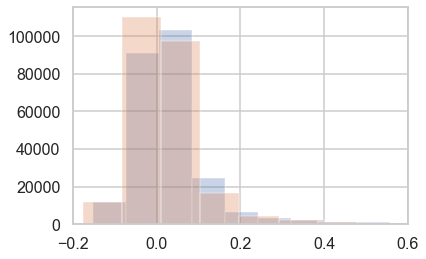

In [15]:
plt.hist(resp_ad.ravel(), bins=100, alpha=0.3, label='AD');
plt.hist(resp_tg.ravel(), bins=100, alpha=0.3, label='TG');
plt.xlim(-0.2, 0.6);

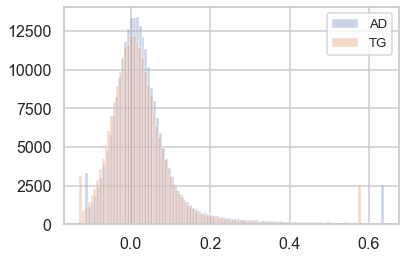

In [12]:
# # cap resp to thres_perc percentile of trials

# thres_perc = 1
# low, high = np.percentile(resp_ad.flatten(), [thres_perc, 100-thres_perc])
# resp_ad = np.clip(resp_ad, low, high)
# plt.hist(resp_ad.ravel(), bins=100, alpha=0.3, label='AD');

# low, high = np.percentile(resp_tg.flatten(), [thres_perc, 100-thres_perc])
# resp_tg = np.clip(resp_tg, low, high)
# plt.hist(resp_tg.ravel(), bins=100, alpha=0.3, label='TG')
# plt.legend();

## group by 10 trials

In [17]:
resp_ad.shape

(169, 1473)

In [492]:
mean_or_median = np.median # for population, median is better than mean

resp_ad_pop = mean_or_median(resp_ad, axis=0) # population response as avg or median of all cells for each trial
resp_tg_pop = mean_or_median(resp_tg, axis=0)

adp_norm_diff = (resp_tg_pop - resp_ad_pop) / (resp_ad_pop + 1e-7) # difference over baseline
adp_IOU = (resp_tg_pop - resp_ad_pop) / (resp_tg_pop + resp_ad_pop + 1e-7) # difference over sum
adp_norm_diff.shape, mean_or_median(adp_norm_diff), mean_or_median(adp_IOU) # group_size = 1, use all cell resp mean or median

((491,), -0.10224070617654166, -0.04507483451503533)

In [536]:
adp_type = []
thres = 5

for key in stim_type_dict.keys():
    
    resp_ad_type = resp_ad[:, np.where((np.isin(stim_id, stim_type_dict[key])))[0]]
    resp_ad_type = np.sum(resp_ad_type, axis=1) # [ncell]. sum over trials
    resp_tg_type = resp_tg[:, np.where((np.isin(stim_id, stim_type_dict[key])))[0]]
    resp_tg_type = np.sum(resp_tg_type, axis=1)

    adp_type_now = (resp_tg_type - resp_ad_type) / (resp_ad_type + 1e-7)
    adp_type_now[np.abs(adp_type_now) > thres] = np.nan
    adp_type.append(adp_type_now) # [ntype, ncell]

# adp_type = np.array(adp_type)
adp_type[0].shape, len(adp_type)

((116,), 3)

In [537]:
df = pd.DataFrame()
for i,key in enumerate(stim_type_dict.keys()):
    print(i, key)
    df_type = pd.DataFrame(adp_type[i], columns=['adp'])
    df_type['type'] = key
    df = pd.concat([df, df_type])
df = df.reset_index(drop=True)

# replace adp with nan
# df.loc[df.adp.abs() > 5, 'adp'] = np.nan

df

0 natural
1 grat
2 noise


,adp,type
0,0.205867,natural
1,-3.593621,natural
2,-0.223799,natural
3,-0.355143,natural
4,-0.241573,natural
...,...,...
343,-0.646405,noise
344,0.012251,noise
345,-0.179685,noise
346,-0.028059,noise


In [538]:
df.groupby('type').adp.median()

type
grat      -0.133538
natural    0.009932
noise     -0.030523
Name: adp, dtype: float64

In [541]:
adp_type_mean = [np.nanmedian(i) for i in adp_type]
adp_type_mean

[0.009932345235814662, -0.13353787831638936, -0.03052273866144662]

(-1.0, 1.0)

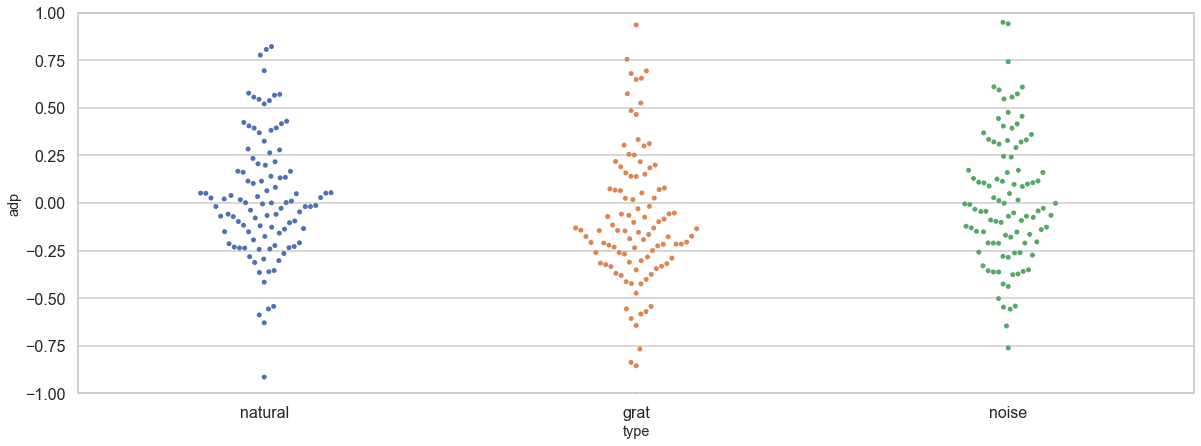

In [526]:
# swarmplot of adp_type
plt.figure(figsize=(20, 7))
ax = sns.swarmplot(x="type", y="adp", data=df)
plt.plot(adp_type_mean)
plt.ylim(-1,1)

# sns.swarmplot(data=adp_type[0], palette='Set1')
# plt.xlabel('ADP type'); plt.ylabel('ADP');
# plt.title('ADP type');
# plt.legend(list(stim_type_dict.keys()), frameon=False);


In [ ]:
# use pop resp. group all 9-10 trials together for each stim, then compare stim type


# # for whole population, loop thru trial numbers to group together to get a stable adaptation value  
# adp_agg = []
# adp_std = []
# for group_size in np.arange(1, trace_by_trial.shape[1] // 2):
#     ngroup = trace_by_trial.shape[1] // group_size

#     resp_ad_cut = resp_ad_pop[:group_size*ngroup].reshape(ngroup, group_size) # reshape to ngroup x group_size
#     resp_tg_cut = resp_tg_pop[:group_size*ngroup].reshape(ngroup, group_size)
#     resp_ad_group = mean_or_median(resp_ad_cut, axis=1) # aggregate resp within group of trials
#     resp_tg_group = mean_or_median(resp_tg_cut, axis=1)

#     adp_group = (resp_tg_group - resp_ad_group) / (resp_ad_group + 1e-7) # calc adp with `avg resp within group`
#     adp_group_agg = mean_or_median(adp_group) # agg adp across group
#     adp_group_std = np.std(adp_group) # std of adp across group
#     adp_agg.append(adp_group_agg) # group_size variable, all cell resp agg
#     adp_std.append(adp_group_std)

# adp_agg = np.array(adp_agg)
# adp_std = np.array(adp_std)
# adp_sem = adp_std / np.sqrt(adp_std.shape[0])